## STEP 1:

### Importing the important libraries and dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smrut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\smrut\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# ### Importing the Dataset
data = pd.read_csv('spam_data.csv')
data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
12,spam,URGENT! You have won a 1 week FREE membership ...,NaN,NaN,NaN
2899,ham,Come aftr &lt;DECIMAL&gt; ..now i m cleaning ...,NaN,NaN,NaN
1371,ham,I though we shd go out n have some fun so bar ...,NaN,NaN,NaN
5538,ham,I can't believe how attached I am to seeing yo...,NaN,NaN,NaN
2808,ham,Oh yeah I forgot. U can only take 2 out shoppi...,NaN,NaN,NaN


## STEP 2:

### Initial Exploration And Data Cleaning

In [3]:
data.shape

(5572, 5)

In [4]:
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [5]:
data.rename(columns={'v1': 'result', 'v2': 'emails'}, inplace=True)

In [6]:
data

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
data.isnull().sum()

result    0
emails    0
dtype: int64

In [8]:
data.duplicated().sum()

403

In [9]:
data = data.drop_duplicates(keep='first')

In [10]:
data.shape

(5169, 2)

In [11]:
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Step 3:

### <b>Exploratory Data Analysis (EDA)</b>

#### 1- Distribution of Labels

In [12]:
data['result'].value_counts()

result
ham     4516
spam     653
Name: count, dtype: int64

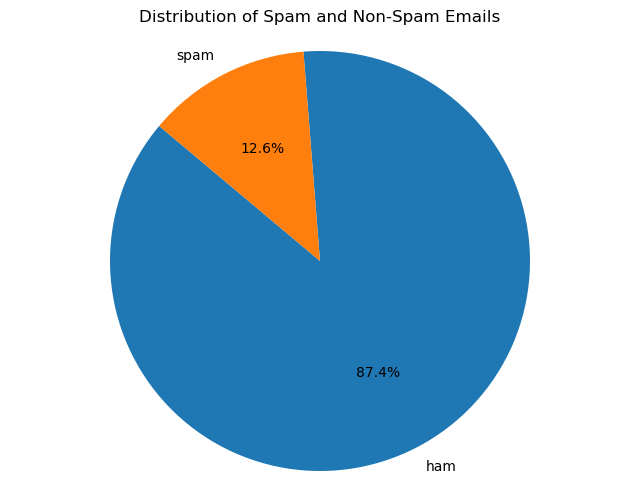

In [13]:
#Plotting
plt.figure(figsize=(8, 6))
plt.pie(data['result'].value_counts(), labels=data['result'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal') 
plt.show()

<blockquote>From the above graph we can see most emails in the dataset (87.4%) are non-spam (ham), while only a smaller portion (12.6%) are classified as spam. This difference is important because it affects how well our model can spot spam emails. Since there are many more non-spam emails, the model might become biased and miss some spam emails. To fix this, we need to use special techniques when training and testing our model. By doing this, we can make sure our model is good at finding both spam and non-spam emails, keeping our email inboxes safe and clutter-free.</blockquote>

#### 2- Average Length of Emails for Spam and Ham

In [14]:
data.loc[:, 'Length'] = data['emails'].apply(len)

C:\Users\smrut\AppData\Local\Temp\ipykernel_25968\3357086539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'Length'] = data['emails'].apply(len)


In [15]:
data.loc[:, 'num_words'] = data['emails'].apply(word_tokenize).apply(len)

C:\Users\smrut\AppData\Local\Temp\ipykernel_25968\3448591551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'num_words'] = data['emails'].apply(word_tokenize).apply(len)


In [16]:
data.loc[:, 'num_sentence'] = data['emails'].apply(sent_tokenize).apply(len)

C:\Users\smrut\AppData\Local\Temp\ipykernel_25968\1229465944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'num_sentence'] = data['emails'].apply(sent_tokenize).apply(len)


In [17]:
data.head(5)

,result,emails,Length,num_words,num_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [18]:
avg_length_spam = data[data['result'] == 'spam']['Length'].mean()

In [19]:
avg_length_ham = data[data['result'] == 'ham']['Length'].mean()

Average Length of Spam Emails: 137.89127105666157
Average Length of Ham Emails: 70.45925597874225


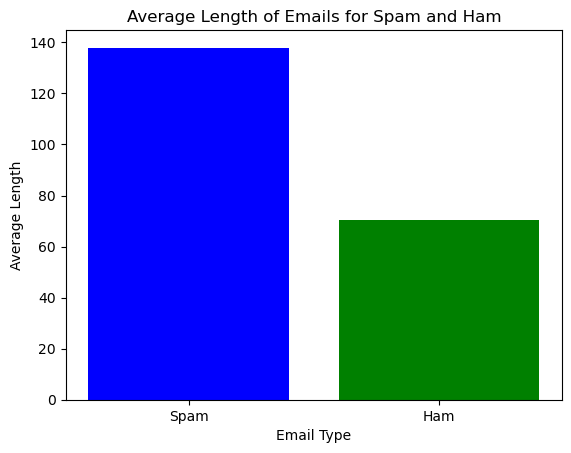

In [20]:
#plotting
print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Ham Emails:", avg_length_ham)
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

#### 3- Average Word of Emails for Spam and Ham

In [21]:
avg_word_spam = data[data['result'] == 'spam']['num_words'].mean()
avg_word_ham = data[data['result'] == 'ham']['num_words'].mean()
print("Average Words of Spam Emails:", avg_word_spam)
print("Average Words of Ham Emails:", avg_word_ham)

Average Words of Spam Emails: 27.6676875957121
Average Words of Ham Emails: 17.12378210806023


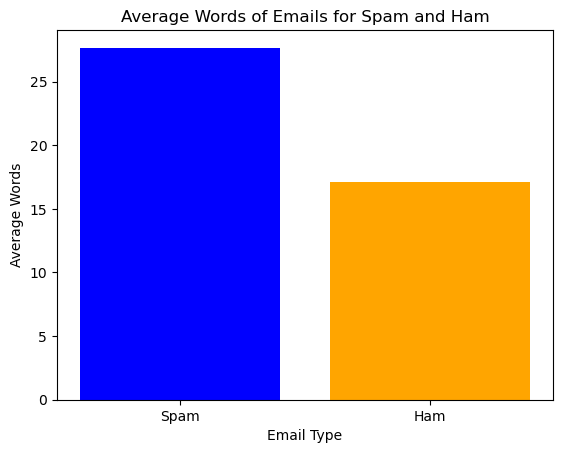

In [22]:
# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['Blue', 'orange'])
plt.title('Average Words of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Words')
plt.show()

#### 4-  Average Sentence of Emails for Spam and Ham

In [23]:
avg_sentence_spam = data[data['result'] == 'spam']['num_sentence'].mean()
avg_sentence_ham = data[data['result'] == 'ham']['num_sentence'].mean()
print("Average Sentence of Spam Emails:", avg_sentence_spam)
print("Average Sentence of Ham Emails:", avg_sentence_ham)

Average Sentence of Spam Emails: 2.970903522205207
Average Sentence of Ham Emails: 1.8201948627103632


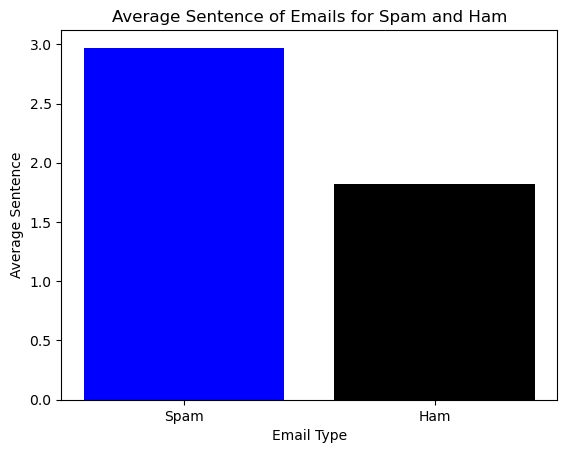

In [24]:
# Plotting the graph
plt.bar(['Spam', 'Ham'], [avg_sentence_spam, avg_sentence_ham], color=['Blue', 'black'])
plt.title('Average Sentence of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Sentence')
plt.show()

#### 5-  Relationship between Length and Spam

In [25]:
correlation = data['Length'].corr((data['result'] == 'spam').astype(int))
print("Correlation coefficient between email length and spam classification:", correlation)

Correlation coefficient between email length and spam classification: 0.3847170667143069


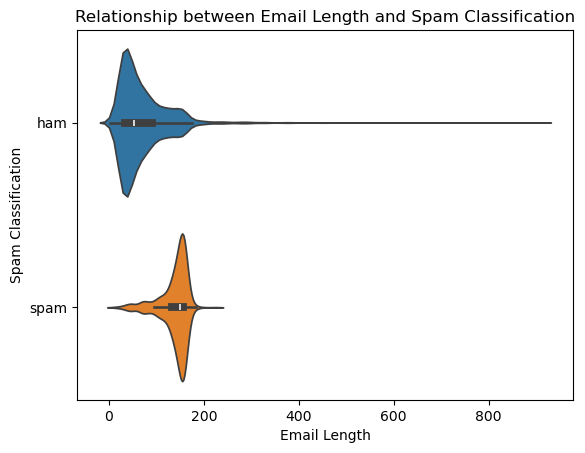

In [26]:
sns.violinplot(data=data, x='Length', y='result', hue='result')
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between Email Length and Spam Classification')
plt.show()

#### 6- Relationship between Features

In [27]:
correlation_matrix = data[['Length', 'num_words', 'num_sentence']].corr()
print("The Relationship between Features are ",correlation_matrix )

The Relationship between Features are                  Length  num_words  num_sentence
Length        1.000000   0.965760      0.624139
num_words     0.965760   1.000000      0.679971
num_sentence  0.624139   0.679971      1.000000


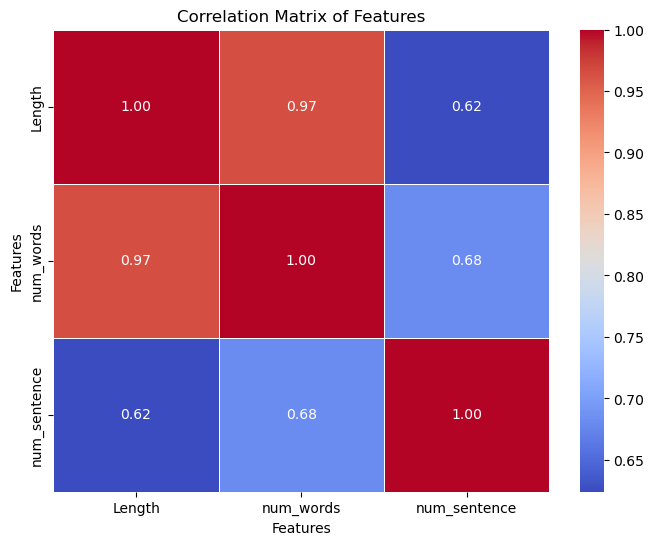

In [28]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

## STEP 4:

### Data Preprocessing

<ul>
<li>Lower case</li>
<li>Tokenization</li>
<li>Removing special characters</li>
<li>Removing stop words and punctuation</li>
<li>Stemming</li>
</ul>

In [29]:
data.loc[:, 'transform_text'] = data['emails'].str.lower()

C:\Users\smrut\AppData\Local\Temp\ipykernel_25968\2230168266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'transform_text'] = data['emails'].str.lower()


In [30]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y=[]
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stop_words and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
        
    return " ".join(y)

In [31]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [32]:
data['emails'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [33]:
data.loc[:, 'transform_text'] = data['emails'].apply(transform_text)

In [34]:
data.head()

,result,emails,Length,num_words,num_sentence,transform_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [35]:
data.dtypes

result            object
emails            object
Length             int64
num_words          int64
num_sentence       int64
transform_text    object
dtype: object

#### 7- Most Common Words in Spam Emails

In [36]:
spam_emails = data[data['result'] == 'spam']['transform_text']

In [37]:
# Tokenize the text in spam emails
spam_words = ' '.join(spam_emails).split()

In [38]:
# Count occurrences of each word
word_counts = Counter(spam_words)

In [39]:
# Find the most common words
most_common_words = word_counts.most_common(10)
print("Top 10 Most Common Words in Spam Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

Top 10 Most Common Words in Spam Emails:
call: 320 occurrences
free: 191 occurrences
2: 155 occurrences
txt: 141 occurrences
text: 122 occurrences
u: 119 occurrences
ur: 119 occurrences
mobil: 114 occurrences
stop: 104 occurrences
repli: 103 occurrences


(-0.5, 799.5, 399.5, -0.5)

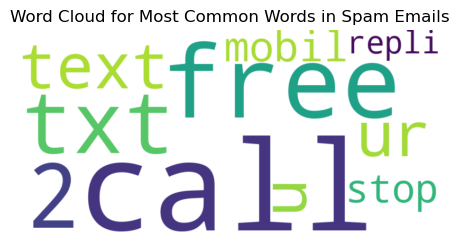

In [40]:
# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam Emails')
plt.axis('off')

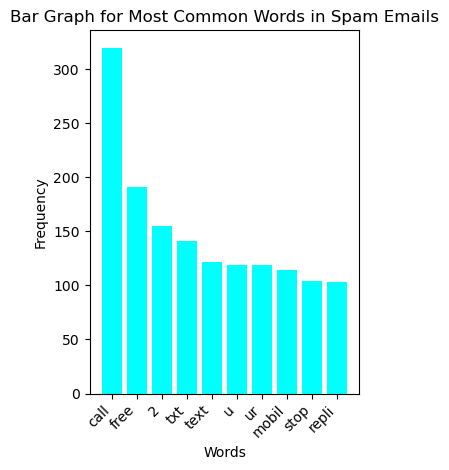

In [41]:
# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='cyan')
plt.title('Bar Graph for Most Common Words in Spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 8-  Most Common Words in Ham Emails

In [42]:
ham_emails = data[data['result'] == 'ham']['transform_text']

In [43]:
# Tokenize the text in spam emails
ham_words = ' '.join(ham_emails).split()

In [44]:
# Count occurrences of each word
word_counts = Counter(ham_words)

In [45]:
# Find the most common words
most_common_words = word_counts.most_common(10)
print("Top 10 Most Common Words in ham Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

Top 10 Most Common Words in ham Emails:
u: 883 occurrences
go: 404 occurrences
get: 349 occurrences
gt: 288 occurrences
lt: 287 occurrences
2: 284 occurrences
come: 275 occurrences
got: 236 occurrences
know: 236 occurrences
like: 234 occurrences


(-0.5, 799.5, 399.5, -0.5)

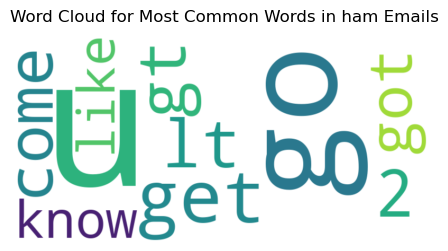

In [46]:
 # Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))
# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in ham Emails')
plt.axis('off')

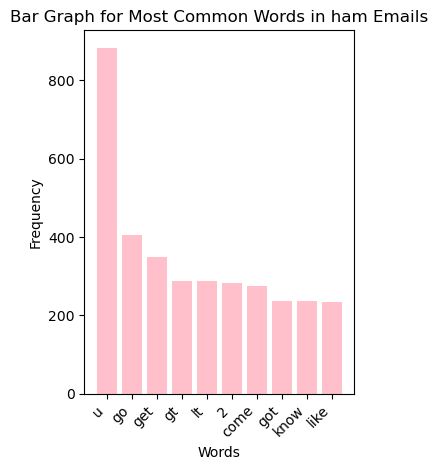

In [47]:
# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='pink')
plt.title('Bar Graph for Most Common Words in ham Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## STEP 5:

### Preparing Data for Machine Learning: Label Encoding and Vectorization

In [48]:
encoder = LabelEncoder()
data['result'] = encoder.fit_transform(data['result'])

C:\Users\smrut\AppData\Local\Temp\ipykernel_25968\230654040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['result'] = encoder.fit_transform(data['result'])


In [49]:
data.head()

,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [50]:
# data spliting and vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['emails']).toarray()
y = data['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## STEP 6:

### Model Building

#### Model 1- SVC

In [51]:
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)
y_pred_svc = svc_classifier.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_svc))
print("Precision Score: ",precision_score(y_test,y_pred_svc))

SVM Accuracy: 0.99
confusion Matrix : [[889   0]
 [ 14 131]]
Precision Score:  1.0


#### Model 2- Random Forest classifier

In [52]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_rf))
print("Precision Score: ",precision_score(y_test,y_pred_rf))

Random Forest Accuracy: 0.98
confusion Matrix : [[888   1]
 [ 17 128]]
Precision Score:  0.9922480620155039


#### Model 3- Naive Bayes classifier

In [53]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_nb))
print("Precision Score: ",precision_score(y_test,y_pred_nb))

Naive Bayes Accuracy: 0.98
confusion Matrix : [[889   0]
 [ 24 121]]
Precision Score:  1.0


### Choosing the Best Classifier for Email Spam Detection

In [54]:
# Calculate precision scores for each classifier
precision_svc = precision_score(y_test, y_pred_svc)
precision_rf = precision_score(y_test, y_pred_rf)
precision_nb = precision_score(y_test, y_pred_nb)

In [55]:
# Create lists to store accuracies and precision scores
classifiers = ['SVC', 'Random Forest', 'Naive Bayes']
accuracies = [accuracy_svc, accuracy_rf, accuracy_nb]
precision_scores = [precision_svc, precision_rf, precision_nb]

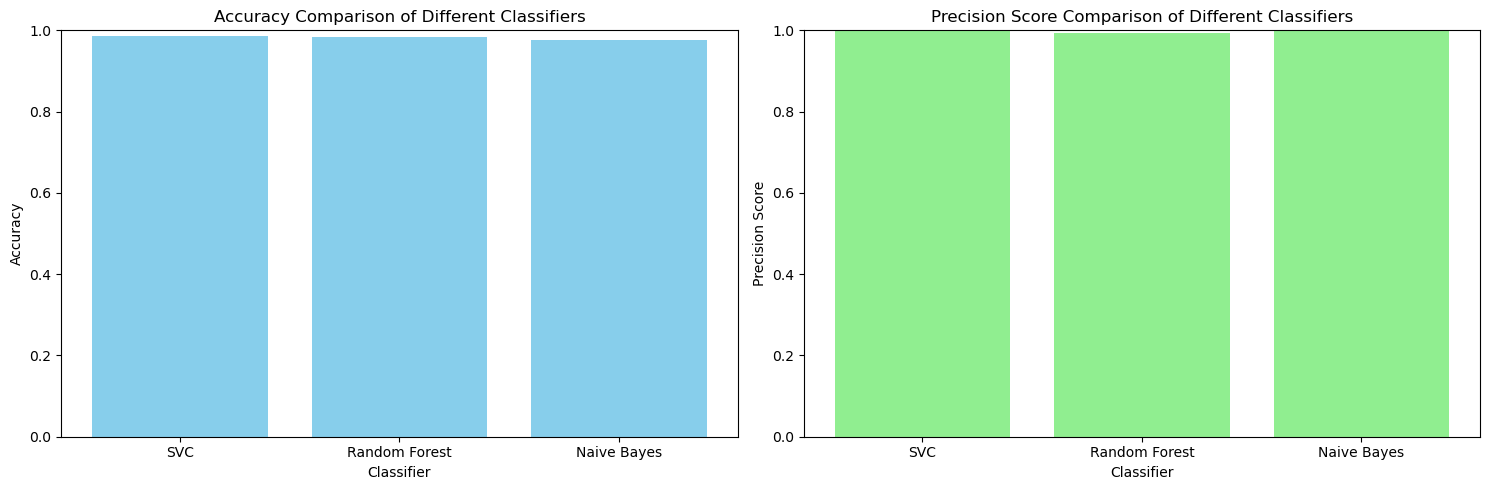

In [56]:
# Plot bar graph for accuracies and precision scores side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot bar graph for accuracies
axes[0].bar(classifiers, accuracies, color='skyblue')
axes[0].set_xlabel('Classifier')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison of Different Classifiers')
axes[0].set_ylim(0, 1)

# Plot bar graph for precision scores
axes[1].bar(classifiers, precision_scores, color='lightgreen')
axes[1].set_xlabel('Classifier')
axes[1].set_ylabel('Precision Score')
axes[1].set_title('Precision Score Comparison of Different Classifiers')
axes[1].set_ylim(0, 1)
plt.tight_layout()
plt.show()

## STEP 6- Model Prediction

<blockquote>Finally, we demonstrate how our trained Naive Bayes model can be used to predict whether new emails are spam or ham. We provide examples of predicting spam or ham status for sample email texts, showcasing the model’s ability to classify emails in real-world scenarios.</blockquote>

### Type 1- Predict with new data

In [60]:
new_emails = [
    "Get a free iPhone now!",
    "Hey, how's it going?",
    "Congratulations! You've won a prize!",
    "Reminder: Meeting at 2 PM tomorrow."
]

# Convert new data into numerical vectors using the trained tfidf_vectorizer
new_X = tfidf.transform(new_emails)
new_X_dense = new_X.toarray()

# Use the trained SVM model to make predictions
svm_predictions = nb_classifier.predict(new_X_dense)

# Print the predictions
for email, prediction in zip(new_emails, svm_predictions):
    if prediction == 1:
        print(f"'{email}' is predicted as spam.")
    else:
        print(f"'{email}' is predicted as ham.")

'Get a free iPhone now!' is predicted as ham.
'Hey, how's it going?' is predicted as ham.
'Congratulations! You've won a prize!' is predicted as spam.
'Reminder: Meeting at 2 PM tomorrow.' is predicted as ham.


### Type 2- User Input Data Prediction

In [66]:
def predict_email(email):
    # Convert email into numerical vector using the trained TF-IDF vectorizer
    email_vector = tfidf.transform([email])

    # Convert sparse matrix to dense array
    email_vector_dense = email_vector.toarray()

    # Use the trained SVM model to make predictions
    prediction = nb_classifier.predict(email_vector_dense)

    # Print the prediction
    if prediction[0] == 1:
        print("The email is predicted as spam.")
    else:
        print("The email is predicted as ham.")

# Get user input for email
user_email = input("Enter the email text: ")

# Predict whether the input email is spam or ham
predict_email(user_email)

Enter the email text:  Subject: Urgent: Your Account Has Been Compromised!  Dear User,  We have detected suspicious activity in your account. To avoid any further issues, please verify your account information immediately by clicking the link below:  [Verify Account]  Failure to verify your information within 24 hours may result in your account being locked.  Thank you for your prompt attention to this matter.  Sincerely, Security Team


The email is predicted as spam.
